In [1]:
import os
import cv2
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from skimage.color import rgb2gray
from pathlib2 import Path

from utils import imread
from drawBlobs import drawBlobs

from mergeImages import mergeImages
from utils import showMatches
from computeSift import compute_sift

# from detectBlobs import detectBlobs
# from computeMatches import computeMatches
# from ransac import ransac

# Scale-space blob detection

In [2]:
from scipy.ndimage import generic_laplace, gaussian_laplace
from scipy.ndimage.filters import gaussian_laplace, minimum_filter, gaussian_filter
from skimage.feature import blob_dog, blob_log, blob_doh

In [3]:
# blobs_log = blob_log(rgb2gray(im), max_sigma=30, num_sigma=10, threshold=.1)
# # Compute radii in the 3rd column.
# blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)

# fig, ax = plt.subplots()
# ax.set_title('Blob Detection')
# ax.imshow(im)
# for blob in blobs_log:
#     y, x, r = blob
#     c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
#     ax.add_patch(c)
# ax.set_axis_off()

In [4]:
from scipy.ndimage import gaussian_filter, gaussian_laplace
from math import sqrt, log
from scipy import spatial

from skimage.feature.blob import _format_exclude_border, _blob_overlap
from skimage.feature.peak import _get_peak_mask, _exclude_border #peak_local_max, 

In [5]:
def _prune_blobs(blobs_array, overlap, scores, sigma_dim=1):
    """Eliminated blobs with area overlap.
    """
    sigma = blobs_array[:, -sigma_dim:].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - sigma_dim)
    tree = spatial.cKDTree(blobs_array[:, :-sigma_dim])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if _blob_overlap(blob1, blob2, sigma_dim=sigma_dim) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                    scores[j] = 0
                else:
                    blob1[-1] = 0
                    scores[i] = 0
    return np.stack([b for b in blobs_array if b[-1] > 0]), np.stack([s for s in scores if s > 0])

def _get_high_intensity_peaks(image, mask, num_peaks):
    """
    Return the highest intensity peak coordinates.
    """
    # get coordinates of peaks
    coord = np.nonzero(mask)
    intensities = image[coord]
    # Highest peak first
    idx_maxsort = np.argsort(-intensities)
    coord = np.stack(coord, axis=-1)[idx_maxsort]
    score = intensities[idx_maxsort]
    # select num_peaks peaks
    if len(coord) > num_peaks:
        coord = coord[:num_peaks]
        score = score[:num_peaks]
    return coord, score

def peak_local_max(image, min_distance=1, threshold_abs=None,
                   threshold_rel=None, exclude_border=True, indices=True,
                   num_peaks=np.inf, footprint=None, num_peaks_per_label=np.inf):
    """Find peaks in an image as coordinate list or boolean mask.
    """
    out = np.zeros_like(image, dtype=np.bool)
    threshold_abs = threshold_abs if threshold_abs is not None else image.min()

    # no peak for a trivial image
    if np.all(image == image.flat[0]):
        if indices is True:
            return np.empty((0, image.ndim), np.int)
        else:
            return out

    # Non maximum filter
    mask = _get_peak_mask(image, min_distance, footprint, threshold_abs,
                          threshold_rel)

    mask = _exclude_border(mask, exclude_border)

    # Select highest intensities (num_peaks)
    coordinates, scores = _get_high_intensity_peaks(image, mask, num_peaks)

    if indices is True:
        return coordinates, scores
    else:
        nd_indices = tuple(coordinates.T)
        out[nd_indices] = True
        return out


def detectBlobs(image, min_sigma=1, max_sigma=50, num_sigma=10, threshold=.1,
             overlap=.5, log_scale=False, *, exclude_border=False):
    image = rgb2gray(image)
    # Gaussian filter requires that sequence-type sigmas have same
    # dimensionality as image. This broadcasts scalar kernels
    if np.isscalar(max_sigma):
        max_sigma = np.full(image.ndim, max_sigma, dtype=float)
    if np.isscalar(min_sigma):
        min_sigma = np.full(image.ndim, min_sigma, dtype=float)

    # Convert sequence types to array
    min_sigma = np.asarray(min_sigma, dtype=float)
    max_sigma = np.asarray(max_sigma, dtype=float)

    if log_scale:
        # for anisotropic data, we use the "highest resolution/variance" axis
        standard_axis = np.argmax(min_sigma)
        start = np.log10(min_sigma[standard_axis])
        stop = np.log10(max_sigma[standard_axis])
        scale = np.logspace(start, stop, num_sigma)[:, np.newaxis]
        sigma_list = scale * min_sigma / np.max(min_sigma)
    else:
        scale = np.linspace(0, 1, num_sigma)[:, np.newaxis]
        sigma_list = scale * (max_sigma - min_sigma) + min_sigma

    # computing gaussian laplace
    # average s**2 provides scale invariance
    gl_images = [-gaussian_laplace(image, s) * np.mean(s) ** 2
                 for s in sigma_list]

    image_cube = np.stack(gl_images, axis=-1)

    exclude_border = _format_exclude_border(image.ndim, exclude_border)
    local_maxima, scores = peak_local_max(
        image_cube,
        threshold_abs=threshold,
        footprint=np.ones((3,) * (image.ndim + 1)),
        threshold_rel=0.0,
        exclude_border=exclude_border,
    )

    # Catch no peaks
    if local_maxima.size == 0:
        return np.empty((0, 3))

    # Convert local_maxima to float64
    lm = local_maxima.astype(np.float64)

    # translate final column of lm, which contains the index of the
    # sigma that produced the maximum intensity value, into the sigma
    sigmas_of_peaks = sigma_list[local_maxima[:, -1]]

    # if scalar_sigma:
    # select one sigma column, keeping dimension
    sigmas_of_peaks = sigmas_of_peaks[:, 0:1]

    # Remove sigma index and replace with sigmas
    lm = np.hstack([lm[:, :-1], sigmas_of_peaks])

    sigma_dim = sigmas_of_peaks.shape[1]

    lm, scores = _prune_blobs(lm, overlap, scores, sigma_dim=sigma_dim)
    lm[:, 2] = lm[:, 2] * math.sqrt(2)
    return np.concatenate((lm, scores[:,np.newaxis]), axis=-1)[:,[1,0,2,3]]

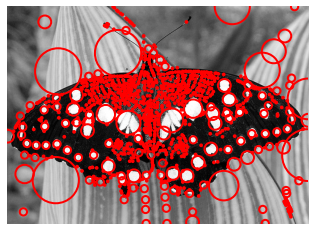

In [6]:
imageName = 'butterfly.jpg'
numBlobsToDraw = 1000
imName = imageName.split('.')[0]

datadir = os.path.join('..', 'data', 'blobs')
im = imread(os.path.join(datadir, imageName))

blobs = detectBlobs(im, max_sigma=30, num_sigma=10, threshold=.1)
drawBlobs(im, blobs, numBlobsToDraw)

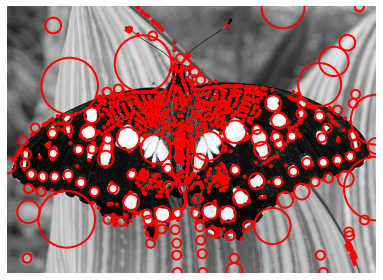

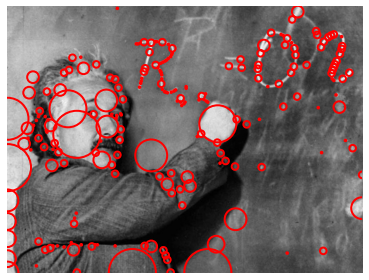

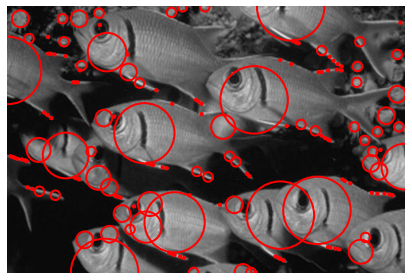

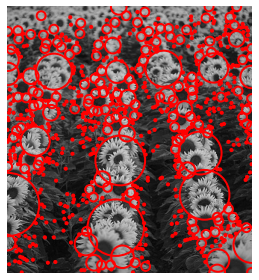

In [6]:
numBlobsToDraw = 1000
blob_root = Path('..', 'data', 'blobs')
image_paths = [d for d in blob_root.iterdir() if d.is_file() and d.suffix=='.jpg']
for image_path in image_paths:
    im = imread(str(image_path))
    blobs = detectBlobs(im, max_sigma=30, num_sigma=10, threshold=.1)
    drawBlobs(im, blobs, numBlobsToDraw, name=image_path.stem)

In [136]:
images

[WindowsPath('../data/blobs/butterfly.jpg'),
 WindowsPath('../data/blobs/einstein.jpg'),
 WindowsPath('../data/blobs/fishes.jpg'),
 WindowsPath('../data/blobs/sunflowers.jpg')]

# Image stitching

In [6]:
def computeMatches(f1, f2):
    """ Match two sets of SIFT features f1 and f2 """
    def ssd(A, B):
        return ((A-B)**2).sum()

    N, d = f1.shape
    THRES = 0.8
    matches = -np.ones(N, dtype=int)
    for i, a in enumerate(f1):
        difs = []
        for j, b in enumerate(f2):
            dif = ssd(a, b)
            difs.append(dif)

        order = np.argsort(difs)
        if difs[order[0]]/difs[order[1]] < 0.8: 
            matches[i] = order[0]
    return matches

In [7]:
def ransac(matches, blobs1, blobs2):
    N=500
    THRES = 10
    valid = np.where(matches!=-1)[0]
    best_err = np.inf
    best_m = np.empty((2,3), dtype=float)

    def calculate_matrix():#matches, valid, blobs1, blobs2):
        seeds = np.random.choice(valid, 3)
        pairs = [(i,j) for i, j in zip(seeds, matches[seeds])]
        left, right1, right2 = [], [], []
        for pair in pairs:
            idx1, idx2 = pair
            left.append(np.append(blobs2[idx2][:2], 1))
            right1.append(blobs1[idx1][0:1])
            right2.append(blobs1[idx1][1:2])
        (m1, m2, t1) = np.linalg.solve(left, right1)
        (m3, m4, t2) = np.linalg.solve(left, right2)
        M = np.array([
            [m1[0], m2[0], t1[0]],
            [m3[0], m4[0], t2[0]]
        ])
        return M

    def calculate_error(M, source, target):
        return sqrt(((M[0] * np.append(source[:2], 1)).sum() - target[0])**2 + ((M[1] * np.append(source[:2], 1)).sum() - target[1])**2)

    def total_err(M):
        err = 0
        inliers = []
        for idx in valid:
            source = blobs2[matches[idx], :2]
            target = blobs1[idx, :2]
            single_err = calculate_error(M, source, target)
            err += single_err
            if single_err < THRES:
                inliers.append(idx)
        return err, inliers

    best_inliers_num = 0
    best_inliers = None
    best_m = None
    
    for i in range(N):
        try:
            M = calculate_matrix()
        except np.linalg.LinAlgError:
            continue
        err, inliers = total_err(M)
        # print('Total ERROR: ', err, '\n')
        if len(inliers) > best_inliers_num:
            best_inliers_num = len(inliers)
            best_inliers = inliers
            best_m = M

    return best_inliers, best_m

In [19]:
#Image directory
dataDir = os.path.join('..', 'data', 'stitching')

#Read input images
testExamples = ['book', 'hill', 'house', 'kitchen', 'park', 'pier', 'roof', 'table', 'eg']

for idx in range(len(testExamples)):
    imageName1 = '{}_1.jpg'.format(testExamples[idx])
    imageName2 = '{}_2.jpg'.format(testExamples[idx])

    im1 = imread(os.path.join(dataDir, imageName1))
    im2 = imread(os.path.join(dataDir, imageName2))

    #Detect keypoints
    blobs1 = detectBlobs(im1, num_sigma=50, threshold=.1)
    blobs2 = detectBlobs(im2, num_sigma=50, threshold=.1)

    #Compute SIFT features
    sift1 = compute_sift(im1, blobs1[:, 0:4])
    sift2 = compute_sift(im2, blobs2[:, 0:4])

    #Find the matching between features
    matches = computeMatches(sift1, sift2)
    # showMatches(im1, im2, blobs1, blobs2, matches, title=f"step1_{testExamples[idx]}")
    # plt.savefig(f'../output/Q2/step1_{testExamples[idx]}.png')

    #Ransac to find correct matches and compute transformation
    inliers, transf = ransac(matches, blobs1, blobs2)
    print(r"\textbf{"+testExamples[idx]+":}\n")
    print(r"$\begin{bmatrix}")
    print(f"{' & '.join([str(round(i, 4)) for i in transf[0]])}\\\\")
    print(f"{' & '.join([str(round(i, 4)) for i in transf[1]])}")
    print(r"\end{bmatrix}$"+"\n\n")

    # goodMatches = -np.ones_like(matches)
    # goodMatches[inliers] = matches[inliers]

    # showMatches(im1, im2, blobs1, blobs2, goodMatches, title=f"step2_{testExamples[idx]}")
    # plt.savefig(f'../output/Q2/step2_{testExamples[idx]}.png')

    #Merge two images and display the output
    # stitchIm = mergeImages(im1, im2, transf)
    # plt.figure()
    # plt.tight_layout()
    # plt.imshow(stitchIm)
    # plt.title('stitched image: {}'.format(testExamples[idx]))
    # plt.savefig(f'../output/Q2/step3_{testExamples[idx]}.png')

\textbf{book:}

$\begin{bmatrix}
0.9902 & -0.016 & 205.6173\\
0.0386 & 1.0118 & 11.1158
\end{bmatrix}$


\textbf{hill:}

$\begin{bmatrix}
0.98 & -0.0283 & -122.9323\\
-0.0126 & 1.0219 & 19.852
\end{bmatrix}$


\textbf{house:}

$\begin{bmatrix}
0.9923 & 0.0165 & 277.7408\\
-0.0039 & 1.0083 & -1.1296
\end{bmatrix}$


\textbf{kitchen:}

$\begin{bmatrix}
0.9814 & 0.0049 & 139.3037\\
0.091 & 0.9129 & 13.1418
\end{bmatrix}$


\textbf{park:}

$\begin{bmatrix}
0.9875 & -0.0265 & 108.4563\\
0.1196 & 0.9508 & 1.8475
\end{bmatrix}$


\textbf{pier:}

$\begin{bmatrix}
1.0 & 0.0 & 243.0\\
0.0014 & 0.9818 & 15.2102
\end{bmatrix}$


\textbf{roof:}

$\begin{bmatrix}
0.9225 & -0.0101 & 79.756\\
0.087 & 0.97 & -1.7425
\end{bmatrix}$


\textbf{table:}

$\begin{bmatrix}
1.0119 & -0.0357 & 142.2857\\
0.142 & 0.9399 & 3.9443
\end{bmatrix}$


\textbf{eg:}

$\begin{bmatrix}
1.0003 & 0.0331 & 147.6045\\
-0.0288 & 1.0373 & -27.9056
\end{bmatrix}$


